In [1]:
!pip install --upgrade biopython nglview ipywidgets gudhi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 84.6 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 77.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.3 MB/s eta 0:00:00a 0:00:01m
  Created wheel for nglview: filename=nglview-3.0.8-py3-none-any.whl size=10216160 sha256=df26042889d9021c93e9649c5955b8dad8d1b2a6742a732f2b9aebf1e4dca2fa
  Stored in directory: /home/onyxia/.cache/pip/wheels/2e/6c/59/32bf4aa0134f9c4cdca054f5192839fb4285241e2f17f7d358
Successfully built nglview


## Visualization of .pdb file

In [1]:
from Bio.PDB import *
import nglview as nv
import ipywidgets
import gudhi

In [2]:
cif_parser = MMCIFParser()
structure = cif_parser.get_structure("6EBK", "/home/onyxia/work/TDA_Protein3D/data/AF-P04637-F1-model_v4.cif")
#pdb_parser = PDBParser(QUIET=True)
#structure = pdb_parser.get_structure("6EBK", "/home/onyxia/work/TDA_Protein3D/notebooks/test.pdb")
view = nv.show_biopython(structure)

In [3]:
view

NGLWidget()

## Processing .pdb files to turn them into graphs

Some ressources that might be worth looking into

- [proteingraph package](https://pypi.org/project/proteingraph/) (does not seem to work)
- Graphein

In [25]:
!pip install graphein         # For base install
!pip install graphein[extras] # For additional featurisation dependencies

In [27]:
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph

data = "/home/onyxia/work/TDA_Protein3D/data/"
# Load the default config
c = ProteinGraphConfig(granularity='CA')

# Construct the graph!
g = construct_graph(config=c, path= data + 'test.pdb')

"""
Figure out what the DEBUG does
"""

Output()

[12/23/23 20:57:54] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=512822;file:///opt/mamba/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=167158;file:///opt/mamba/lib/python3.10/site-packages/graphein/protein/graphs.py#187\187]8;;\

                    DEBUG    Detected 283 total nodes                                                 ]8;id=534091;file:///opt/mamba/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=344448;file:///opt/mamba/lib/python3.10/site-packages/graphein/protein/graphs.py#431\431]8;;\

'\nFigure out what the DEBUG does\n'

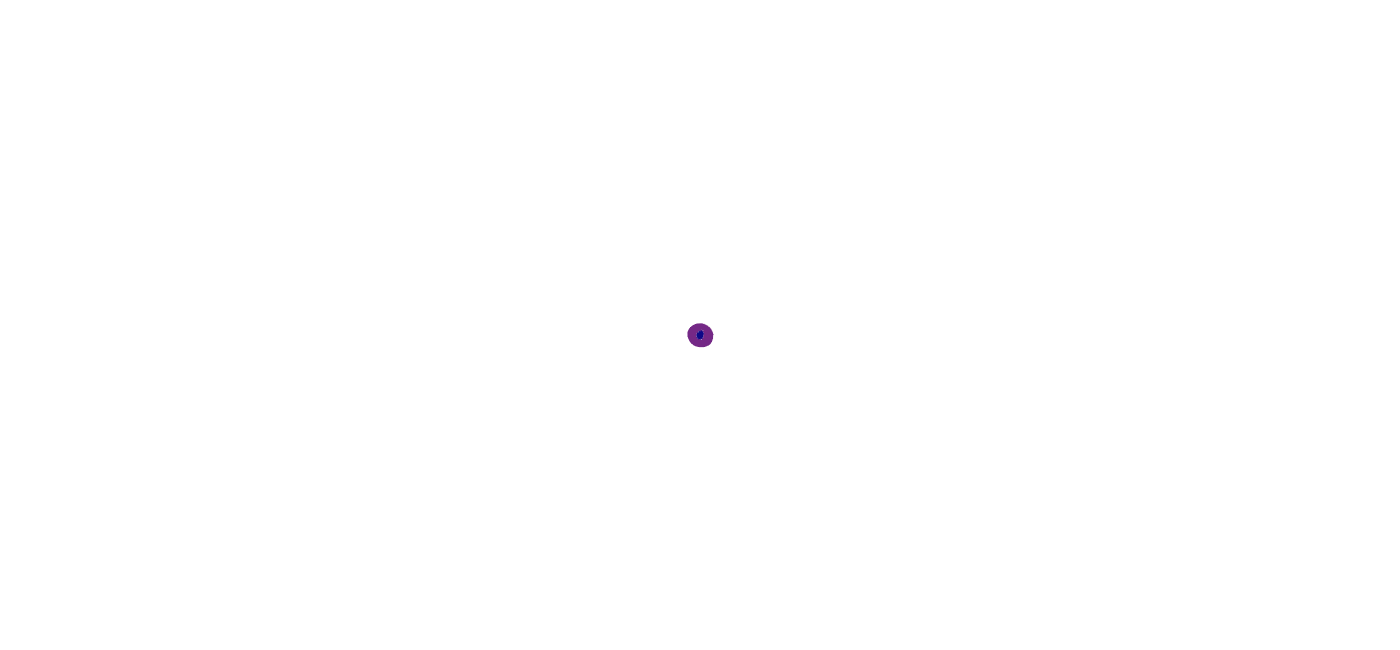

In [28]:
from graphein.protein.visualisation import plotly_protein_structure_graph

plotly_protein_structure_graph(g, node_size_multiplier=0.2, colour_nodes_by="residue_name")

## Extracting atoms coordinates from PDB file 

Code extracted from this [git repo](https://github.com/maduprey/protein-conformation-topology/blob/main/notebooks/protein-conformation-topology.ipynb)


Useful reads :

- Persistence curves ([paper on the theory](https://arxiv.org/abs/1904.07768), [package used](https://github.com/azlawson/PersistenceCurves))
- https://github.com/skolouri/TopoTrans/tree/main
- https://towardsdatascience.com/persistent-homology-with-examples-1974d4b9c3d0

In [37]:
!pip install ripser
#!pip install -q git+https://github.com/azlawson/PersistenceCurves.git

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

from Bio.PDB import PDBParser
from ripser import ripser
from persim import wasserstein

In [3]:
parser = PDBParser(PERMISSIVE=1, QUIET=True)

In [7]:
data = "/home/onyxia/work/TDA_Protein3D/data/3D_for_KOs/K12064/struct/"
structure = parser.get_structure(data + 'TARA_A100001391_G_scaffold164780_2_gene124539.pdb', data + 'TARA_A100001391_G_scaffold164780_2_gene124539.pdb')

# Generate a list of the protein's atoms' R^3 coordinates
coords = []
for atom in structure.get_atoms():
    coords.append(list(atom.get_vector()))
coords = np.array(coords)

In [8]:
coords

array([[ -4.95800018,   4.67399979,  58.92599869],
       [ -5.86999989,   3.90899992,  58.07899857],
       [ -5.91400003,   4.48500013,  56.66799927],
       ...,
       [-21.08499908,  25.35000038, -24.09600067],
       [-21.39800072,  23.88899994, -23.80200005],
       [-22.42499924,  23.74799919, -22.72699928]])

## Computing distances between persistence diagrams

In [6]:
!pip install pot ripser matplotlib scikit-learn

In [5]:
import os
import numpy as np 
from ripser import Rips
import ot
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pickle
import time
from sklearn.manifold import MDS, Isomap
import polars as pl

In [6]:
from frugal_kos import get_layers_for_kos

In [7]:
interesting_KOs = ['K03214'] #,'K05934','K19736'
df = get_layers_for_kos('/home/onyxia/work/TDA_Protein3D/data/Tara_relevant_genes.parquet', interesting_KOs, '/home/onyxia/work/TDA_Protein3D/data/Table_W4.csv')\
    .select(['gene','KO', 'sequence', 'Layer'])

In [8]:
df = df.sort(pl.col('Layer'))

In [9]:
gene_id = [df.rows()[i][0] for i in range(df.shape[0])]
layers = [df.rows()[i][3] for i in range(df.shape[0])]

nb_DCM = layers.count('DCM')
nb_MES = layers.count('MES')
nb_SRF = layers.count('SRF')

ind_DCM = nb_DCM-1
ind_MES = nb_DCM + nb_MES - 1 
ind_SRF = nb_DCM + nb_MES + nb_SRF - 1

In [10]:
layers[19]

'MES'

In [11]:
all_coords = []
parser = PDBParser(PERMISSIVE=1, QUIET=True)


for KO in interesting_KOs:
    for gene in gene_id:
        coords = []
        filename = gene +'.pdb'
        path_prot=  f"/home/onyxia/work/TDA_Protein3D/data/3D_for_KOs/{KO}/struct/{filename}"
        structure = parser.get_structure(path_prot, path_prot)
        for atom in structure.get_atoms():
            coords.append(list(atom.get_vector()))
        coords = np.array(coords)
        all_coords.append(coords)


In [16]:
all_coords[0].shape

(1864, 3)

IndexError: list index out of range

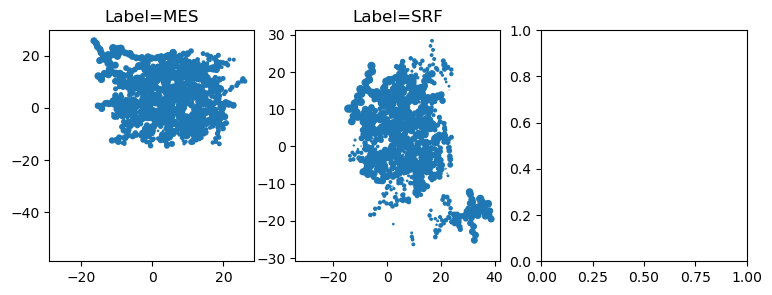

In [86]:
"""
Plotting of 3 proteins, each one coming from a different layer
"""

inds = [ind_DCM,ind_MES,ind_SRF] #indexes that separate each label
fig,ax = plt.subplots(1,3,figsize=(9,3))
for i in range(3):
    ax[i].scatter(all_coords[inds[i]][:,0],all_coords[inds[i]][:,1], all_coords[inds[i]][:,2])
    ax[i].set_title('Label=%s'%layers[inds[i]])

In [82]:
layers[inds[1]] #atoms of the protein that has index in inds[1], supposedly the last MES protein

len(all_coords[inds[1]][:,0]) #ensemble des x de nos atomes

2096

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data

# Assuming you have two arrays of shape (100, 3)
array1 = np.random.rand(100, 3)
array2 = np.random.rand(100, 3)

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(, 2, 1, projection='3d')

# Assuming you want to plot the first array as a surface
X1, Y1 = np.meshgrid(np.arange(array1.shape[0]), np.arange(array1.shape[1]))
Z1 = array1[X1, Y1]
surf = ax.plot_surface(X1, Y1, Z1, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(np.min(Z1), np.max(Z1))
fig.colorbar(surf, shrink=0.5, aspect=10)

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# Assuming you want to plot the second array as a wireframe
X2, Y2 = np.meshgrid(np.arange(array2.shape[0]), np.arange(array2.shape[1]))
Z2 = array2[X2, Y2]
ax.plot_wireframe(X2, Y2, Z2, rstride=10, cstride=10)

plt.show()


ValueError: Number of rows must be a positive integer, not (-70, 70)

<Figure size 960x480 with 0 Axes>

In [20]:
array1[0]

array([0.3554137 , 0.65881537, 0.09108071])

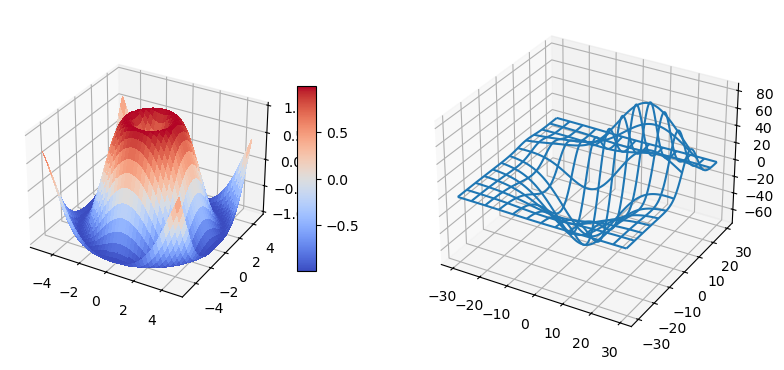

In [69]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 1.01)
fig.colorbar(surf, shrink=0.5, aspect=10)

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo
X, Y, Z = get_test_data(0.05)
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

plt.show()

## Calculating persistence using Rips diagram

In [ ]:
rips = Rips()
fig, axs = plt.subplots(3,2,figsize=(12,10))
for n,i in enumerate(inds):        
    plt.axes(axs[n,0])
    plt.scatter(X[i][:,0],X[i][:,1],s=5)
    plt.axis('equal')
    D=rips.fit_transform(X[i])
    plt.axes(axs[n,1])
    rips.plot(D)